In [1]:
#filename = "data_test.txt"
filename = "data.txt"
#filename = "data_test1.txt"

In [2]:
with open(filename,"r") as f:
    lines = f.read().splitlines()

In [3]:
lines

['9165985876154699219988192797299938946759548993842382179897895847959995468789384779887969965834298757',
 '9998264799399739852669159899969915752881369928979589425659869512849898348591988899941938989958981368',
 '8899439372928798295981284899995498957198997822776999766989269673341115866632499916582179985999797178',
 '9421373314798816327241583824298987799745811978869899899899999689988933652499891999899718759652641398',
 '9949959989598519929632977671926983547787167773939739198988988851889519228348573848979828599971727943',
 '2989192448779756984992587956689999842746119939998567894718899918799954281648927282191699499764931166',
 '9536499426969676189784443598979559899499773119978188394689557995599331996979736693529419681251956996',
 '1751936936954979779895998917863998697858138691879749999727789764741997539275579593798975539798818972',
 '7274746616894977772987689459988988891794769772199789185982726479992789563994126143759648659653627929',
 '97682111786492699959234939121769686666799998598299138

In [4]:
#Plan,

#Start from end
# Iterate for points around it (up and left)
# As moving towards left and up, check the calculated risk for going right or down
# and store direction (down or right) that gives minimum risk.

In [5]:
#Convert data to array of ints
data=[]
for l in lines:
    data0=[]
    for i in range(len(l)):
        c = l[i]
        data0.append(int(c))
    data.append(data0)


In [6]:
import numpy as np
data_np = np.array(data, dtype=np.int8)

In [7]:
data_np

array([[9, 1, 6, ..., 7, 5, 7],
       [9, 9, 9, ..., 3, 6, 8],
       [8, 8, 9, ..., 1, 7, 8],
       ...,
       [9, 3, 6, ..., 7, 7, 9],
       [1, 6, 5, ..., 1, 9, 9],
       [9, 7, 8, ..., 9, 3, 7]], dtype=int8)

In [8]:
#Generate map 5 times bigger
sy,sx = data_np.shape
dataexp5 = data_np.copy()


In [9]:
data_low = dataexp5.copy()

for ny in range(1,5):
    #Expand down
    data_low = data_low +1
    data_low = np.where(data_low==10, 1 , data_low)
    dataexp5 = np.append(dataexp5, data_low, axis=0)

In [10]:
dataexp5

array([[9, 1, 6, ..., 7, 5, 7],
       [9, 9, 9, ..., 3, 6, 8],
       [8, 8, 9, ..., 1, 7, 8],
       ...,
       [4, 7, 1, ..., 2, 2, 4],
       [5, 1, 9, ..., 5, 4, 4],
       [4, 2, 3, ..., 4, 7, 2]], dtype=int8)

In [11]:
#Expand horizontally
dataexp5r = dataexp5.copy()
data_right = dataexp5r.copy()

for nx in range(1,5):
    #Expand right
    data_right = data_right +1
    data_right = np.where(data_right==10, 1 , data_right)
    dataexp5r = np.append(dataexp5r, data_right, axis=1)

In [12]:
dataexp5r #OK

array([[9, 1, 6, ..., 2, 9, 2],
       [9, 9, 9, ..., 7, 1, 3],
       [8, 8, 9, ..., 5, 2, 3],
       ...,
       [4, 7, 1, ..., 6, 6, 8],
       [5, 1, 9, ..., 9, 8, 8],
       [4, 2, 3, ..., 8, 2, 6]], dtype=int8)

In [13]:
best_risk_from_bottom_right = np.zeros_like(dataexp5r, dtype=np.int32)

In [14]:
best_dir = np.zeros_like(dataexp5r) # 0 for down, 1 for right

In [15]:
class IterFromBottomRight:
    ''' Iterates coordinates from bottom right including the corner element
    '''

    ix=None
    iy=None
    includeBRCorner = False

    def get_diag(self):
        return (self.sizex+self.sizey-2) - self.ix-self.iy

    def __init__(self, shape):
        self.sizey, self.sizex = shape

    def __iter__(self):

        return self

    def __next__(self):
        #first element?
        if self.ix is None:
            self.ix = self.sizex-1
            self.iy = self.sizey-1

        # Next iteration

        cur_diag = self.get_diag()
        self.ix += 1
        #diag = (self.sizex+self.sizey-2) - self.ix-self.iy
        temp0 = (self.sizex+self.sizey-2) - cur_diag
        self.iy = temp0 - self.ix

        if self.ix >= self.sizex or self.iy<0:
            #print(f"new ix {ix} is >= sizex or iy={iy}<0")
            #print("Next diagonal")
            # off limit, got to next diagonal
            cur_diag += 1

            #Try starting at the bottom
            self.iy = self.sizey-1
            temp0 = (self.sizex+self.sizey-2) - cur_diag
            self.ix = temp0-self.iy

            if self.ix<0: #off limit, start at the left side instead
                #print("ix off grid")
                self.ix=0
                self.iy = temp0 - self.ix
                if self.iy<0:
                    #print("Complete")
                    raise StopIteration #Should stop at next iteration, not here!

        
        return self.iy, self.ix, self.get_diag()


In [16]:
#Do one initial cycle
myiter = IterFromBottomRight(dataexp5r.shape)
yx_iter = iter( IterFromBottomRight(dataexp5r.shape) )

In [17]:
sizey, sizex = dataexp5r.shape

for iy,ix,idiag in yx_iter:
    print(f"iy,ix,idiag = {iy},{ix},{idiag}")
    #What is the risk from here?
    
    riskdown=None
    riskright = None
    bestdir0 = None #1 - right, 2 - down #3 for left # 4 - up
    
    #down
    iy1 = iy+1
    if iy1 < sizey:
        riskdown = dataexp5r[iy1,ix] + best_risk_from_bottom_right[iy1,ix]
    #right
    ix1 = ix+1
    if ix1<sizex:
        riskright = dataexp5r[iy,ix1] + best_risk_from_bottom_right[iy,ix1]
    
    if riskdown is None:
        risk=riskright
        bestdir0 = 1
    elif riskright is None:
        risk=riskdown
        bestdir0= 2
    elif riskdown<riskright:
        risk = riskdown
        bestdir0 = 2
    else:
        risk=riskright
        bestdir0=1
    
    best_risk_from_bottom_right[iy,ix] = risk
    best_dir[iy,ix]= bestdir0

iy,ix,idiag = 499,498,1
iy,ix,idiag = 498,499,1
iy,ix,idiag = 499,497,2
iy,ix,idiag = 498,498,2
iy,ix,idiag = 497,499,2
iy,ix,idiag = 499,496,3
iy,ix,idiag = 498,497,3
iy,ix,idiag = 497,498,3
iy,ix,idiag = 496,499,3
iy,ix,idiag = 499,495,4
iy,ix,idiag = 498,496,4
iy,ix,idiag = 497,497,4
iy,ix,idiag = 496,498,4
iy,ix,idiag = 495,499,4
iy,ix,idiag = 499,494,5
iy,ix,idiag = 498,495,5
iy,ix,idiag = 497,496,5
iy,ix,idiag = 496,497,5
iy,ix,idiag = 495,498,5
iy,ix,idiag = 494,499,5
iy,ix,idiag = 499,493,6
iy,ix,idiag = 498,494,6
iy,ix,idiag = 497,495,6
iy,ix,idiag = 496,496,6
iy,ix,idiag = 495,497,6
iy,ix,idiag = 494,498,6
iy,ix,idiag = 493,499,6
iy,ix,idiag = 499,492,7
iy,ix,idiag = 498,493,7
iy,ix,idiag = 497,494,7
iy,ix,idiag = 496,495,7
iy,ix,idiag = 495,496,7
iy,ix,idiag = 494,497,7
iy,ix,idiag = 493,498,7
iy,ix,idiag = 492,499,7
iy,ix,idiag = 499,491,8
iy,ix,idiag = 498,492,8
iy,ix,idiag = 497,493,8
iy,ix,idiag = 496,494,8
iy,ix,idiag = 495,495,8
iy,ix,idiag = 494,496,8
iy,ix,idiag = 49

In [18]:
best_dir

array([[1, 2, 1, ..., 2, 2, 2],
       [2, 2, 2, ..., 1, 2, 2],
       [1, 2, 2, ..., 1, 2, 2],
       ...,
       [1, 1, 1, ..., 1, 2, 2],
       [1, 1, 1, ..., 1, 2, 2],
       [1, 1, 1, ..., 1, 1, 0]], dtype=int8)

In [19]:
best_risk_from_bottom_right

array([[3018, 3017, 3012, ..., 2481, 2474, 2628],
       [3016, 3008, 3005, ..., 2474, 2473, 2625],
       [3008, 3000, 2996, ..., 2473, 2471, 2622],
       ...,
       [2518, 2511, 2510, ...,   22,   16,   14],
       [2567, 2566, 2557, ...,   16,    8,    6],
       [2567, 2565, 2562, ...,    8,    6,    0]])

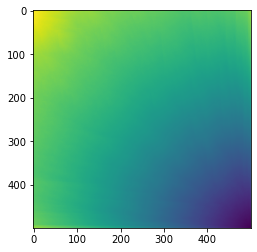

In [20]:
import matplotlib.pyplot as plt
plt.imshow(best_risk_from_bottom_right)

In [21]:
#Now iterate a optmization procedure until no change occurs

#myiter1 = IterFromBottomRight(data_np.shape)
#yx_iter1 = iter( myiter1 )

hasChanged=True
while hasChanged:
    myiter1 = IterFromBottomRight(dataexp5r.shape)
    yx_iter1 = iter( myiter1 )

    hasChanged=False
    for iy,ix,idiag in yx_iter1:
        
        newrisk = None
        newdir = None #1 - right, 2 - down , 3 for left , 4 - up

        cur_risk = best_risk_from_bottom_right[iy,ix]

        #print(f"{iy},{ix} : cur_risk = {cur_risk}")

        #Check all directions for a potential better route
        #down
        iy1 = iy+1
        if iy1 < sizey:
            risk0 = dataexp5r[iy1,ix] + best_risk_from_bottom_right[iy1,ix]
            if risk0 < cur_risk:
                #print("better risk going down")
                newrisk = risk0
                newdir = 2

        #right
        ix1 = ix+1
        if ix1<sizex:
            risk0 = dataexp5r[iy,ix1] + best_risk_from_bottom_right[iy,ix1]
            if risk0 < cur_risk:
                #print("better risk going right")
                newrisk = risk0
                newdir = 1
        
        #up
        iy1 = iy-1
        if iy1 >=0 :
            risk0 = dataexp5r[iy1,ix] + best_risk_from_bottom_right[iy1,ix]
            if risk0 < cur_risk:
                #print("better risk going up")
                newrisk = risk0
                newdir = 4
        
        #left
        ix1 = ix-1
        if ix1>=0:
            risk0 = dataexp5r[iy,ix1] + best_risk_from_bottom_right[iy,ix1]
            if risk0 < cur_risk:
                #print("better risk going left")
                newrisk = risk0
                newdir = 3

        if not newrisk is None:
            #print(f"new risk at {iy},{ix}: {newrisk}")
            hasChanged = True
            best_risk_from_bottom_right[iy,ix] = newrisk
            best_dir[iy,ix] =newdir


In [22]:
best_dir

array([[1, 2, 1, ..., 3, 2, 2],
       [2, 2, 2, ..., 3, 2, 3],
       [1, 2, 2, ..., 3, 3, 3],
       ...,
       [1, 1, 1, ..., 1, 2, 2],
       [1, 2, 1, ..., 1, 2, 2],
       [1, 1, 1, ..., 1, 1, 0]], dtype=int8)

In [23]:
best_risk_from_bottom_right #OK

array([[3016, 3015, 3010, ..., 2117, 2117, 2120],
       [3014, 3006, 3003, ..., 2114, 2116, 2117],
       [3006, 2998, 2994, ..., 2109, 2114, 2116],
       ...,
       [2128, 2121, 2120, ...,   22,   16,   14],
       [2128, 2127, 2120, ...,   16,    8,    6],
       [2127, 2125, 2122, ...,    8,    6,    0]])

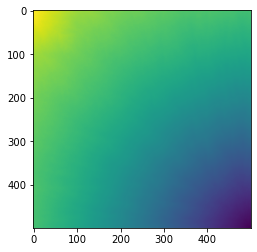

In [24]:
plt.imshow(best_risk_from_bottom_right)

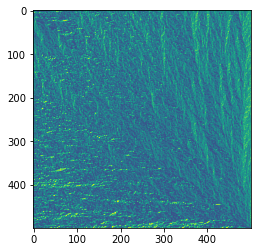

In [25]:
plt.imshow(best_dir)